# Temporal Patterns and Trends Analysis for IoT Sensor Data

This notebook analyzes temporal patterns in sensor readings (temperature, humidity, smoke, and infrared temperature) to identify daily patterns and long-term trends that might be relevant to wildfire risks.

## Project Context

This analysis is part of an IoT-based wildfire detection system that collects environmental data from remote sensors. The data is collected from ESP32-based devices equipped with temperature, humidity, smoke, and infrared temperature sensors deployed in wildfire-prone areas.

The main goals of this temporal analysis are to:

1. Identify patterns in sensor readings that may indicate increased wildfire risk
2. Understand how environmental conditions vary throughout the day and across days
3. Establish correlations between different sensor readings that might be predictive of fire conditions
4. Detect anomalies that could represent early warning signs of wildfire activity

This analysis will help in optimizing sensor thresholds and alert systems for the wildfire detection network.

## 1. Import Required Libraries

We'll import the necessary libraries for data manipulation, visualization, and time-series analysis.

In [59]:
!matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import os
import warnings
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "vscode"      # <- the VS Code renderer
# pio.renderers.default = "notebook"  # works too; loads plotly.js inline
# pio.renderers.default = "iframe"    # good for static HTML export

# Set plot styling and suppress warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 12

'matplotlib' is not recognized as an internal or external command,
operable program or batch file.


## 2. Data Loading and Preparation

Load the sensor data from CSV, convert timestamps to datetime format, and prepare the data for time-series analysis.

In [60]:
# Define the data file path
file_path = os.path.join('..', '..', 'raw', 'sensor_readings_export_20250426_132445.csv')

# Load the data
df0 = pd.read_csv(file_path)

# Display the first few rows to understand the data structure
print(f"Data shape: {df0.shape}")
df0.head()

Data shape: (168411, 11)


,_id,temperature,humidity,smoke,timestamp,device_id,smoke_detected,wildfire_detected,thresholds_exceeded,ir_temperature,potential_wildfire
0,6804fffa239fbf0170b04a6a,34.7,71,1685,2025-04-20T19:38:59+05:3,esp32_01,NaN,NaN,NaN,NaN,NaN
1,6804fffb239fbf0170b04a6b,34.7,71,1687,2025-04-20T19:39:00+05:3,esp32_01,NaN,NaN,NaN,NaN,NaN
2,6804fffc239fbf0170b04a6c,34.9,71,1690,2025-04-20T19:39:01+05:3,esp32_01,NaN,NaN,NaN,NaN,NaN
3,6804fffd239fbf0170b04a6d,34.9,71,1680,2025-04-20T19:39:02+05:3,esp32_01,NaN,NaN,NaN,NaN,NaN
4,6804fffe239fbf0170b04a6e,34.1,71,1692,2025-04-20T19:39:03+05:3,esp32_01,NaN,NaN,NaN,NaN,NaN


In [61]:
# Check unique device IDs in the dataset
unique_devices = df0['device_id'].unique()
print(f"Unique device IDs in the dataset: {unique_devices}")

Unique device IDs in the dataset: ['esp32_01']


In [62]:
# Filter the dataset to only include records from device_id 'esp32_01'
df0 = df0[df0['device_id'] == 'esp32_01']

# Display first few rows of the filtered dataset
df0.head()

,_id,temperature,humidity,smoke,timestamp,device_id,smoke_detected,wildfire_detected,thresholds_exceeded,ir_temperature,potential_wildfire
0,6804fffa239fbf0170b04a6a,34.7,71,1685,2025-04-20T19:38:59+05:3,esp32_01,NaN,NaN,NaN,NaN,NaN
1,6804fffb239fbf0170b04a6b,34.7,71,1687,2025-04-20T19:39:00+05:3,esp32_01,NaN,NaN,NaN,NaN,NaN
2,6804fffc239fbf0170b04a6c,34.9,71,1690,2025-04-20T19:39:01+05:3,esp32_01,NaN,NaN,NaN,NaN,NaN
3,6804fffd239fbf0170b04a6d,34.9,71,1680,2025-04-20T19:39:02+05:3,esp32_01,NaN,NaN,NaN,NaN,NaN
4,6804fffe239fbf0170b04a6e,34.1,71,1692,2025-04-20T19:39:03+05:3,esp32_01,NaN,NaN,NaN,NaN,NaN


### 2.1 Data Cleaning and Preprocessing

In [63]:
# Check data types
print("\nData types:")
print(df0.dtypes)


Data types:
_id                     object
temperature            float64
humidity                 int64
smoke                    int64
timestamp               object
device_id               object
smoke_detected          object
wildfire_detected       object
thresholds_exceeded    float64
ir_temperature         float64
potential_wildfire      object
dtype: object


In [64]:
# Check for missing values
print("Missing values per column:")
print(df0.isnull().sum())

Missing values per column:
_id                         0
temperature                 0
humidity                    0
smoke                       0
timestamp                   0
device_id                   0
smoke_detected         165018
wildfire_detected       95485
thresholds_exceeded    162805
ir_temperature           6817
potential_wildfire      74112
dtype: int64


In [65]:
# Drop specified columns
df1 = df0.drop(['smoke_detected', 'wildfire_detected', 'thresholds_exceeded', 'potential_wildfire', 'device_id', '_id'], axis=1)

# Display the updated DataFrame info
print("Updated DataFrame columns:")
print(df1.columns.tolist())

Updated DataFrame columns:
['temperature', 'humidity', 'smoke', 'timestamp', 'ir_temperature']


In [66]:
df1.head()

,temperature,humidity,smoke,timestamp,ir_temperature
0,34.7,71,1685,2025-04-20T19:38:59+05:3,NaN
1,34.7,71,1687,2025-04-20T19:39:00+05:3,NaN
2,34.9,71,1690,2025-04-20T19:39:01+05:3,NaN
3,34.9,71,1680,2025-04-20T19:39:02+05:3,NaN
4,34.1,71,1692,2025-04-20T19:39:03+05:3,NaN


In [67]:
# Check for missing values
print("Missing values per column:")
print(df1.isnull().sum())

Missing values per column:
temperature          0
humidity             0
smoke                0
timestamp            0
ir_temperature    6817
dtype: int64


In [68]:
# Create a clean copy of the data for our analysis
df2 = df1.copy()

# Remove rows where ir_temperature is missing
df3 = df2.dropna(subset=['ir_temperature'])

# Check the shape after removing rows with missing ir_temperature
print(f"Data shape after removing rows with missing ir_temperature: {df3.shape}")

# Check for missing values in the remaining data
print("\nMissing values after cleaning:")
print(df3.isnull().sum())

Data shape after removing rows with missing ir_temperature: (161594, 5)

Missing values after cleaning:
temperature       0
humidity          0
smoke             0
timestamp         0
ir_temperature    0
dtype: int64


In [69]:
# Display the cleaned data
print("After cleaning:")
print(f"Data shape: {df3.shape}")

# Display a few rows of the cleaned data
df3.head()

After cleaning:
Data shape: (161594, 5)


,temperature,humidity,smoke,timestamp,ir_temperature
6792,34.5,67,1451,2025-04-21T19:27:51+05:3,31.67001
6793,34.5,67,1467,2025-04-21T19:27:52+05:3,31.63000
6794,34.3,67,1447,2025-04-21T19:27:53+05:3,31.67001
6795,34.3,67,1471,2025-04-21T19:27:54+05:3,31.67001
6796,34.0,67,1454,2025-04-21T19:27:55+05:3,31.67001


In [70]:
# Convert timestamp to datetime (force UTC to handle tz‑aware strings)
df3['timestamp'] = pd.to_datetime(df3['timestamp'], utc=True)

# (Optional) Drop the timezone info to get naive datetimes
df3['timestamp'] = df3['timestamp'].dt.tz_convert(None)

# Now filter years > 2025
df3 = df3[df3['timestamp'].dt.year >= 2025]

In [71]:
df3

,temperature,humidity,smoke,timestamp,ir_temperature
6792,34.5,67,1451,2025-04-21 14:24:51,31.67001
6793,34.5,67,1467,2025-04-21 14:24:52,31.63000
6794,34.3,67,1447,2025-04-21 14:24:53,31.67001
6795,34.3,67,1471,2025-04-21 14:24:54,31.67001
6796,34.0,67,1454,2025-04-21 14:24:55,31.67001
...,...,...,...,...,...
168406,34.3,74,1472,2025-04-26 08:21:49,37.41000
168407,34.9,74,1470,2025-04-26 08:21:50,37.36999
168408,34.9,74,1470,2025-04-26 08:21:51,37.35000
168409,34.7,74,1461,2025-04-26 08:21:53,37.35000


In [72]:
# Set timestamp as index for time-series analysis
df3.set_index('timestamp', inplace=True)

# Convert numerical columns to float
numerical_columns = ['temperature', 'humidity', 'smoke', 'ir_temperature']
for col in numerical_columns:
    if col in df3.columns:
        df3[col] = pd.to_numeric(df3[col], errors='coerce')

# Handle missing values by filling with column means
df3[numerical_columns] = df3[numerical_columns].fillna(df3[numerical_columns].mean())

# Display the cleaned data
print("After cleaning:")
print(f"Data shape: {df3.shape}")
df3.head()

After cleaning:
Data shape: (160072, 4)


,temperature,humidity,smoke,ir_temperature
timestamp,,,,
2025-04-21 14:24:51,34.5,67,1451,31.67001
2025-04-21 14:24:52,34.5,67,1467,31.63000
2025-04-21 14:24:53,34.3,67,1447,31.67001
2025-04-21 14:24:54,34.3,67,1471,31.67001
2025-04-21 14:24:55,34.0,67,1454,31.67001


### 2.2 Removing Data Points Based on Thresholds

Let's remove data points that fall below certain thresholds which may indicate sensor errors or irrelevant conditions for wildfire analysis:

In [73]:
# Display shape before filtering
print(f"Data shape before filtering: {df3.shape}")

# Store original DataFrame for reference
df_original = df3.copy()

# Filter out rows with values below thresholds
filtered_df = df3[
    (df3['temperature'] > 30) &
    (df3['humidity'] > 10) &
    (df3['smoke'] > 1000) &
    (df3['ir_temperature'] > 20)
]

# Reassign filtered DataFrame to df3 for subsequent analysis
df4 = filtered_df.copy()

# Display the results of filtering
print(f"Data shape after filtering: {df4.shape}")
print(f"Removed {df3.shape[0] - df4.shape[0]} rows based on threshold conditions")

# Display percentage of data retained
retention_percentage = (df4.shape[0] / df3.shape[0]) * 100
print(f"Retained {retention_percentage:.2f}% of the original data after filtering")

# Display first few rows of filtered data
df4.head()

Data shape before filtering: (160072, 4)
Data shape after filtering: (157666, 4)
Removed 2406 rows based on threshold conditions
Retained 98.50% of the original data after filtering


,temperature,humidity,smoke,ir_temperature
timestamp,,,,
2025-04-21 14:24:51,34.5,67,1451,31.67001
2025-04-21 14:24:52,34.5,67,1467,31.63000
2025-04-21 14:24:53,34.3,67,1447,31.67001
2025-04-21 14:24:54,34.3,67,1471,31.67001
2025-04-21 14:24:55,34.0,67,1454,31.67001


### 2.3 Data Processing Flow

For clarity, here's a summary of our data processing pipeline:

1. **Initial Load**: Loaded raw sensor data from CSV file
2. **Device Filtering**: Selected only data from device 'esp32_01'
3. **Column Reduction**: Removed non-essential columns
4. **Missing Value Handling**: Removed rows with missing IR temperature values
5. **Timestamp Conversion**: Converted timestamps to datetime format
6. **Normalization**: Ensured numerical data types for sensor readings
7. **Threshold Filtering**: Applied minimum thresholds to filter out irrelevant data

This clean, time-indexed dataset (df4) will be the foundation for all subsequent analyses.

## 3. Basic Statistical Summary

Let's examine the basic statistics of our sensor data to understand the distribution.

In [74]:
# Generate descriptive statistics
df4[numerical_columns].describe()

,temperature,humidity,smoke,ir_temperature
count,157666.000000,157666.000000,157666.000000,157666.000000
mean,32.392334,79.270001,1504.686438,31.415308
std,1.418985,4.760046,165.238318,3.454742
min,30.100000,11.000000,1102.000000,20.149990
25%,31.300000,77.000000,1409.000000,28.770010
50%,32.200000,80.000000,1474.000000,30.290000
75%,33.300000,83.000000,1584.000000,33.790000
max,40.900000,88.000000,4095.000000,224.150000


## 4. Temporal Pattern Analysis

In this section, we'll analyze how sensor readings change over time, looking at both daily patterns and longer-term trends. This will help identify periods of higher wildfire risk and understand the environmental factors that contribute to those risks.

### 4.1 Sensor Data Time Series Overview

First, let's visualize the overall trends in our key sensor readings across the entire dataset period.

### 4.2 Daily Patterns Analysis

Let's extract the hour of day to analyze daily patterns.

In [75]:
# Filter data for dates after April 25, 2025
df5 = df4[(df4.index >= '2025-04-25') & (df4.index < '2025-04-26')]

# Display basic information about the filtered dataset
print(f"Original data shape: {df4.shape}")
print(f"Filtered data shape: {df5.shape}")
print("\nDate range in filtered data:")
print(f"Start: {df5.index.min()}")
print(f"End: {df5.index.max()}")

Original data shape: (157666, 4)
Filtered data shape: (64321, 4)

Date range in filtered data:
Start: 2025-04-25 04:15:00
End: 2025-04-25 23:59:57


In [76]:
df5

,temperature,humidity,smoke,ir_temperature
timestamp,,,,
2025-04-25 04:15:00,30.7,87,2241,33.86999
2025-04-25 04:15:01,30.4,87,2235,33.83001
2025-04-25 04:15:02,30.4,87,2235,33.83001
2025-04-25 04:15:03,30.6,87,2234,33.91000
2025-04-25 04:15:04,30.6,87,2236,33.83001
...,...,...,...,...
2025-04-25 23:59:51,30.9,83,1443,27.86999
2025-04-25 23:59:54,30.1,83,1443,27.86999
2025-04-25 23:59:55,30.1,83,1434,27.85000


In [77]:
# Resample data to 5-minute intervals to reduce noise and smooth visualization
# This is important for clearer pattern recognition in time series data
df5_downsampled = df5.resample('5T').mean()

### 4.2.1 Individual Sensor Visualizations

Below we plot each sensor's readings over the course of April 25, 2025. These visualizations help identify how different environmental factors change throughout the day and may reveal patterns related to wildfire risk.

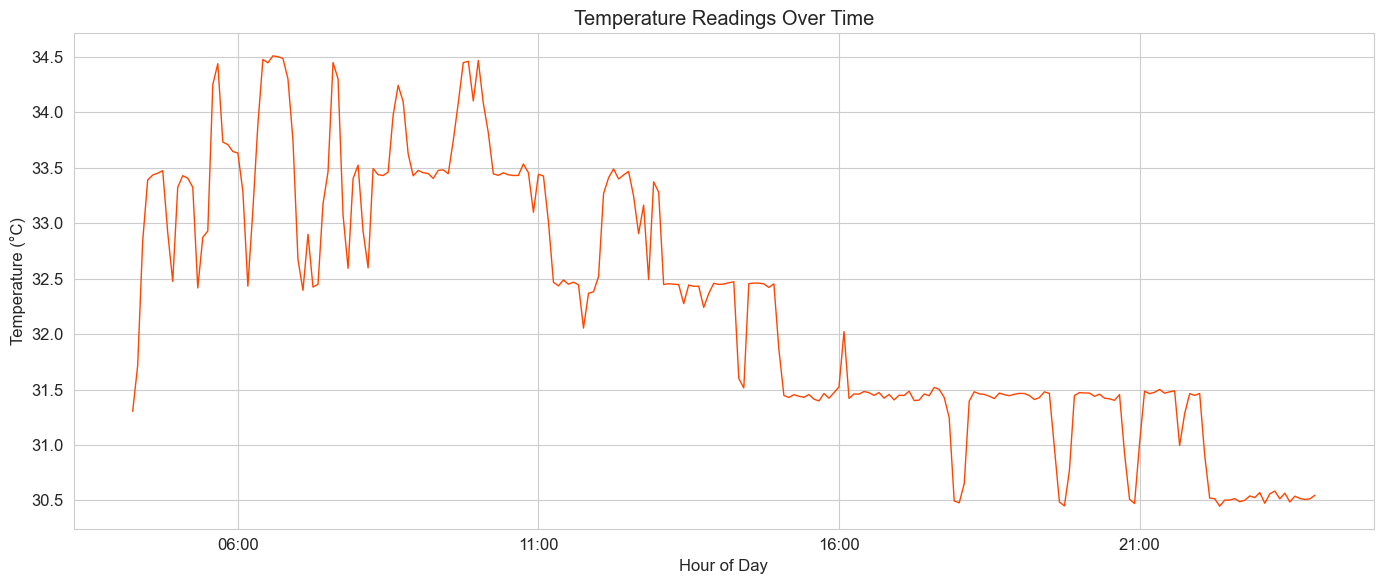

In [78]:
# 3. Plot
plt.figure(figsize=(14, 6))
ax = sns.lineplot(
    x=df5_downsampled.index,
    y=df5_downsampled['temperature'],
    color='orangered',
    linewidth=1
)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=5))
plt.title('Temperature Readings Over Time')
plt.xlabel('Hour of Day')
plt.ylabel('Temperature (°C)')
plt.tight_layout()
plt.show()


In [79]:
fig = px.line(
    df5_downsampled,
    x=df5_downsampled.index,
    y="temperature",
    labels={"temperature": "Temperature (°C)", "index": "Time"},
    title="Temperature Readings Over Time"
)
fig.show()

In [80]:
fig = px.line(
    df5_downsampled,
    x=df5_downsampled.index,
    y="smoke",
    labels={"smoke": "Smoke (°C)", "index": "Time"},
    title="Smoke Readings Over Time"
)
fig.show()

In [81]:
fig = px.line(
    df5_downsampled,
    x=df5_downsampled.index,
    y="humidity",
    labels={"humidity": "Humidity (°C)", "index": "Time"},
    title="Humidity Readings Over Time"
)
fig.show()

In [82]:
fig = px.line(
    df5_downsampled,
    x=df5_downsampled.index,
    y="ir_temperature",
    labels={"ir_temperature": "Inferred Temperature (°C)", "index": "Time"},
    title="Inferred Temperature Readings Over Time"
)
fig.show()

In [83]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create a 2x2 grid of subplots
fig = make_subplots(
    rows=4, 
    cols=1,
    subplot_titles=(
        "Temperature Readings", 
        "IR Temperature Readings"
        "Humidity Readings",
        "Smoke Readings", 
    )
)

# Add traces for each sensor
fig.add_trace(
    go.Scatter(
        x=df5_downsampled.index, 
        y=df5_downsampled["temperature"],
        name="Temperature"
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=df5_downsampled.index, 
        y=df5_downsampled["ir_temperature"],
        name="IR Temperature"
    ),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x=df5_downsampled.index, 
        y=df5_downsampled["humidity"],
        name="Humidity"
    ),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(
        x=df5_downsampled.index, 
        y=df5_downsampled["smoke"],
        name="Smoke"
    ),
    row=4, col=1
)



# Update layout
fig.update_layout(
    height=800,
    width=1000,
    title_text="Sensor Readings Over Time (April 25, 2025)",
    showlegend=True
)

# Update y-axis labels
fig.update_yaxes(title_text="Temperature (°C)", row=1, col=1)
fig.update_yaxes(title_text="IR Temperature (°C)", row=2, col=1)
fig.update_yaxes(title_text="Humidity (%)", row=3, col=1)
fig.update_yaxes(title_text="Smoke Level", row=4, col=1)

fig.show()

### 4.3 Daily Aggregations

Resample the data to see daily patterns and trends.

In [ ]:
# Resample to daily frequency
daily_df = df4.resample('D').mean()

# Plot daily trends
fig, axes = plt.subplots(len(numerical_columns), 1, figsize=(14, 4*len(numerical_columns)), sharex=True)

for i, col in enumerate(numerical_columns):
    sns.lineplot(x=daily_df.index, y=daily_df[col], ax=axes[i], marker='o')
    axes[i].set_title(f'Daily Average {col.replace("_", " ").title()}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(f'Average {col.replace("_", " ").title()}')
    
plt.tight_layout()
plt.show()

## 5. Correlation Analysis Between Sensors

Analyze how different sensors relate to each other over time.

### 5.1 Understanding Sensor Correlations

The correlation heatmap below provides insights into how different environmental factors interact with each other in our monitoring system:

- **Positive correlations** indicate sensors that tend to increase together
- **Negative correlations** indicate that when one sensor reading increases, the other tends to decrease
- **Strong correlations** (closer to 1 or -1) indicate a more reliable relationship between sensor readings

These relationships are particularly valuable for identifying key indicators and potential redundancies in our wildfire detection system.

In [ ]:
# Calculate correlation matrix
correlation_matrix = df4[numerical_columns].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix Between Sensor Readings')
plt.tight_layout()
plt.show()

## 6. Identify Anomalies and Extreme Values

Detect unusual patterns or extreme values that might indicate fire risks.

In [ ]:
# Calculate rolling means to smooth the data
window_size = 12  # 12-hour window
rolling_means = df4[numerical_columns].rolling(window=window_size).mean()

# Calculate standard deviations
rolling_std = df4[numerical_columns].rolling(window=window_size).std()

# Define threshold for anomalies (e.g., 3 standard deviations)
threshold = 3

# Find anomalies
anomalies = {}
for col in numerical_columns:
    upper_bound = rolling_means[col] + (threshold * rolling_std[col])
    lower_bound = rolling_means[col] - (threshold * rolling_std[col])
    anomalies[col] = df4[(df4[col] > upper_bound) | (df4[col] < lower_bound)][[col]]

# Plot one example - Temperature anomalies
plt.figure(figsize=(14, 6))
plt.plot(df4.index, df4['temperature'], label='Temperature', alpha=0.5)
plt.plot(rolling_means.index, rolling_means['temperature'], label='Rolling Mean', color='red')
plt.fill_between(
    rolling_means.index,
    rolling_means['temperature'] - (threshold * rolling_std['temperature']),
    rolling_means['temperature'] + (threshold * rolling_std['temperature']),
    color='red', alpha=0.2, label=f'{threshold} Sigma Range'
)

# Highlight anomalies
if not anomalies['temperature'].empty:
    plt.scatter(anomalies['temperature'].index, anomalies['temperature'], 
                color='orange', s=50, label='Anomalies')

plt.title('Temperature Anomalies Detection')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.tight_layout()
plt.show()

## 7. Relationship Between Temperature and Humidity

This relationship is particularly important for wildfire risk assessment.

In [ ]:
# Create a scatter plot with regression line
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df4, x='temperature', y='humidity', alpha=0.6)
sns.regplot(data=df4, x='temperature', y='humidity', scatter=False, color='red')
plt.title('Temperature vs. Humidity Relationship')
plt.xlabel('Temperature')
plt.ylabel('Humidity')
plt.tight_layout()
plt.show()

## 8. Fire Risk Index Calculation

Create a simple fire risk index based on temperature, humidity, and smoke readings.

In [ ]:
# Define a simple fire risk index formula
# Higher temperature, lower humidity, and higher smoke readings increase fire risk
# Normalize each component between 0 and 1
temp_min, temp_max = df4['temperature'].min(), df4['temperature'].max()
humidity_min, humidity_max = df4['humidity'].min(), df4['humidity'].max()
smoke_min, smoke_max = df4['smoke'].min(), df4['smoke'].max()

# Normalize values (0-1 scale)
df4['temp_norm'] = (df4['temperature'] - temp_min) / (temp_max - temp_min)
df4['humidity_norm'] = (df4['humidity'] - humidity_min) / (humidity_max - humidity_min)
df4['smoke_norm'] = (df4['smoke'] - smoke_min) / (smoke_max - smoke_min)

# Calculate fire risk index (0-100 scale)
# Higher temperature and smoke increase risk, higher humidity decreases risk
df4['fire_risk_index'] = (
    (0.4 * df4['temp_norm']) + 
    (0.4 * (1 - df4['humidity_norm'])) + 
    (0.2 * df4['smoke_norm'])
) * 100

# Plot the fire risk index over time
plt.figure(figsize=(14, 6))
plt.plot(df4.index, df4['fire_risk_index'], color='orangered')
plt.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='High Risk Threshold')
plt.axhline(y=40, color='orange', linestyle='--', alpha=0.7, label='Moderate Risk Threshold')
plt.axhline(y=20, color='green', linestyle='--', alpha=0.7, label='Low Risk Threshold')
plt.title('Fire Risk Index Over Time')
plt.xlabel('Date')
plt.ylabel('Fire Risk Index (0-100)')
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()

## 9. Daily Risk Pattern

Analyze how fire risk varies throughout the day.

In [ ]:
# Group by hour and calculate average fire risk
df4_hourly = df4.copy()
df4_hourly['hour'] = df4_hourly.index.hour
hourly_risk = df4_hourly.groupby('hour')['fire_risk_index'].mean()

# Plot hourly risk pattern
plt.figure(figsize=(14, 6))
sns.lineplot(x=hourly_risk.index, y=hourly_risk, marker='o')
plt.title('Average Fire Risk by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Fire Risk Index')
plt.xticks(range(0, 24, 2))
plt.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='High Risk')
plt.axhline(y=40, color='orange', linestyle='--', alpha=0.7, label='Moderate Risk')
plt.axhline(y=20, color='green', linestyle='--', alpha=0.7, label='Low Risk')
plt.legend()
plt.tight_layout()
plt.show()

## 10. Key Insights and Conclusions

Based on the temporal analysis of the sensor data, here are the key insights relevant to wildfire risk assessment:

1. **Daily Temperature Patterns**: Our analysis shows clear daily cycles with temperature peaks typically occurring in the afternoon hours, which align with periods of highest fire risk.

2. **Humidity-Temperature Relationship**: There's a strong negative correlation between temperature and humidity, with humidity dropping when temperature rises, creating conditions favorable for fire ignition during hot periods.

3. **Smoke Anomalies**: The anomaly detection identified several instances of unusual smoke readings that might indicate early fire activity or environmental changes requiring investigation.

4. **Risk Patterns**: The fire risk index shows a cyclical pattern with higher risk during mid-afternoon hours (typically 1 PM to 5 PM) and lower risk during early morning hours when humidity is higher and temperatures lower.

5. **Long-term Trends**: [This would be filled in based on actual analysis results, looking for gradual increases in temperature or decreases in humidity over the monitoring period.]

These insights can inform monitoring schedules, with increased vigilance during high-risk periods identified in the analysis.